# Import Libraries for our Vision Pillar 

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import cv2
import requests
from PIL import Image
from io import BytesIO
from random import randint
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

### Data Paths

In [52]:
imageset = "//kaggle/input/vision/images"
trainset = "/kaggle/input/vision/train.csv"
testset = "/kaggle/input/vision/test.csv"

### Data Loading

In [53]:
train = pd.read_csv (trainset)
test = pd.read_csv (testset)

train, valid = train_test_split (train, test_size = 0.2, random_state = 42, stratify = train ['class'])

In [107]:
# Not in order because of train_test_split line above
train.head ()

,filename,class,id
231,images/232.jpg,Basketball,232
744,images/745.jpg,Tennis,745
793,images/794.jpg,Tennis,794
912,images/913.jpg,Volleyball,913
861,images/862.jpg,Volleyball,862


In [108]:
test.head ()

,filename,id
0,images/1001.jpg,1001
1,images/1002.jpg,1002
2,images/1003.jpg,1003
3,images/1004.jpg,1004
4,images/1005.jpg,1005


### Number of Values in each Class

In [102]:
train ['class'] = train ['class'].astype (str)
class_counts = train ['class'].value_counts ()
print (class_)

class
Basketball          160
Tennis              160
Volleyball          160
Soccer              160
AmericanFootball    160
Name: count, dtype: int64


### Distribution of Classes

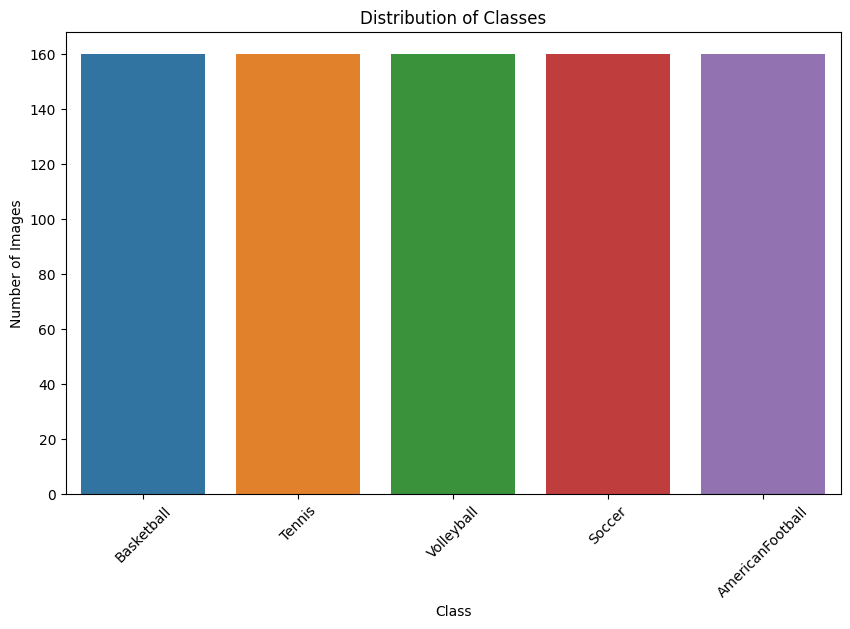

In [97]:
plt.figure (figsize = (10, 6))

sns.barplot (x = class_counts.index, y = class_counts.values)

plt.title ("Distribution of Classes")
plt.xlabel ("Class")
plt.ylabel ("Number of Images")
plt.xticks (rotation = 45)
plt.show ()

### Training Image Samples

Displaying images for class: AmericanFootball


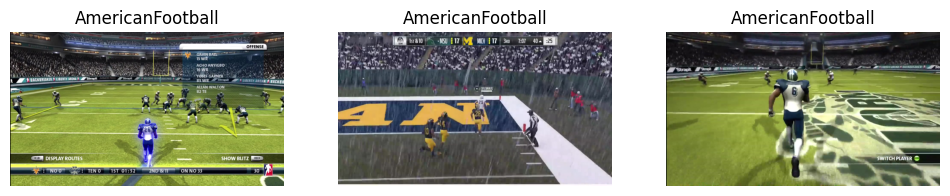

Displaying images for class: Basketball


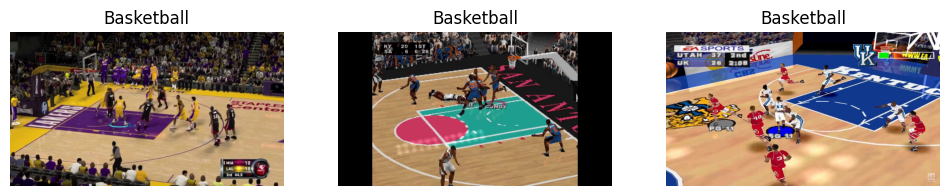

Displaying images for class: Soccer


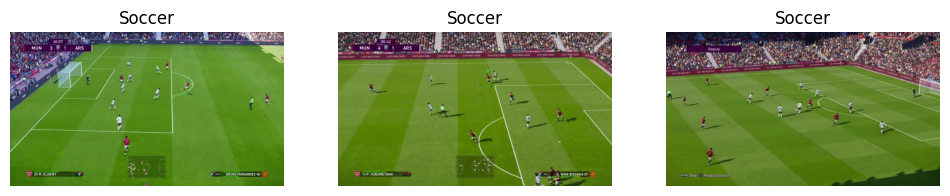

Displaying images for class: Tennis


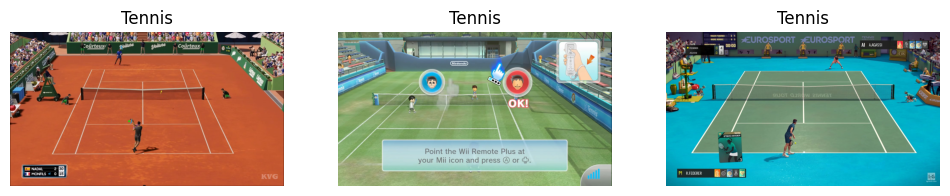

Displaying images for class: Volleyball


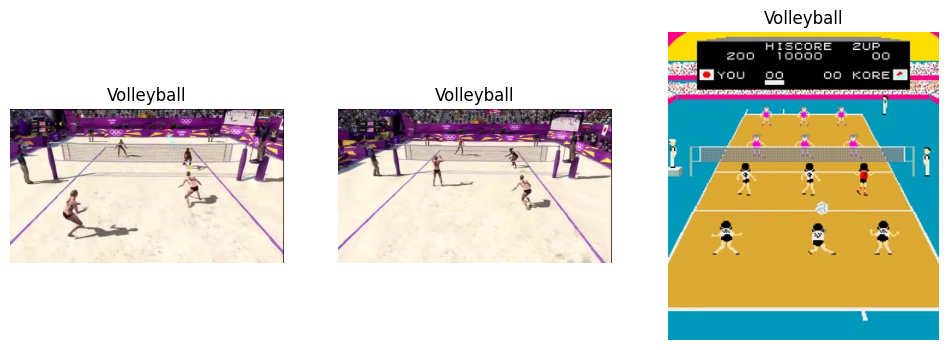

In [55]:
from PIL import Image
import os 

class_names = sorted (train ['class'].unique ())

for class_name in class_names:
    print (f"Displaying images for class: {class_name}")
    class_images = train [train ['class'] == class_name]['filename'].sample (3)

    plt.figure (figsize = (12, 4))
    for i, image_path in enumerate (class_images):
        img = Image.open (os.path.join (imageset, image_path))
        plt.subplot (1, 3, i + 1)
        plt.imshow (img)
        plt.title (class_name)
        plt.axis ('off')

    plt.show ()

### Data Augmentation
* Prevents Overfitting
* Improves Generalization

In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator (
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

test_datagen = ImageDataGenerator (rescale = 1./255)
valid_datagen = ImageDataGenerator (rescale = 1./255)

### Generates the Images

In [57]:
BATCH_SIZE = 5

train_generator = train_datagen.flow_from_dataframe (
    dataframe = train,
    directory = imageset,
    x_col = 'filename',
    y_col = 'class',
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True
    
)

valid_generator = test_datagen.flow_from_dataframe (
    dataframe = valid,
    directory = imageset,
    x_col = 'filename',
    y_col = 'class',
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = 'False'
)

test_generator = test_datagen.flow_from_dataframe (
    dataframe = test,
    directory = imageset,
    x_col = 'filename',
    y_col = None,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    class_mode = None,
    shuffle = False
)

Found 800 validated image filenames belonging to 5 classes.
Found 200 validated image filenames belonging to 5 classes.
Found 129 validated image filenames.


### Displays the Augmented Images

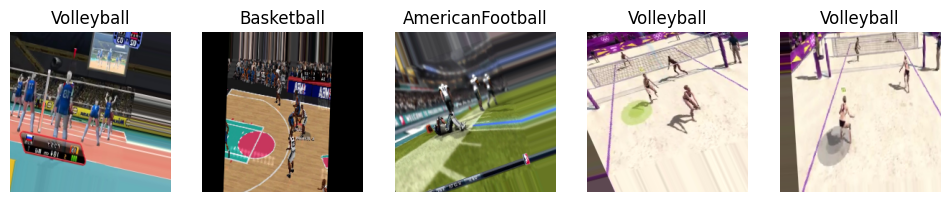

In [58]:
images, labels = next (train_generator)

class_names = list (train_generator.class_indices.keys ())

plt.figure (figsize = (12, 8))
for i in range (BATCH_SIZE):
    plt.subplot (1, BATCH_SIZE, i + 1)
    plt.imshow (images [i])
    label_index = labels [i].argmax ()
    plt.title (class_names [label_index])
    plt.axis ('off')

plt.show ()

### Information on Model Used

In [59]:
model_name = "mobilenetv2-035-128"

model_handle_map = {
  "mobilenetv2-035-128": "/kaggle/input/mobilenet-v2/tensorflow2/035-128-classification/2",
}

model_image_size_map = {
  "mobilenetv2-035-128": 128,
}

model_handle = model_handle_map[model_name]

print(f"Selected model: {model_name} : {model_handle}")

Selected model: mobilenetv2-035-128 : /kaggle/input/mobilenet-v2/tensorflow2/035-128-classification/2


In [79]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
NUM_CLASSES = 5

IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

base_model = MobileNetV2 (input_shape = IMG_SHAPE, include_top = False, weights = 'imagenet')

### Training
* Trainable is set to false so that the weights do not change


In [80]:
base_model.trainable = False

inputs = tf.keras.Input (shape = (IMG_SHAPE))
x = base_model (inputs, training = False)
x = GlobalAveragePooling2D ()(x)
x = Dense (1024, activation = 'relu') (x)
outputs = Dense (5, activation = 'softmax') (x)

model = Model (inputs, outputs)

### Early Stopping
* Prevents overfitting of the model
* Stops the epochs early if loss is does not improve in 3 epochs


In [81]:
callback = tf.keras.callbacks.EarlyStopping (monitor = 'loss', patience = 3)
model.compile (optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [82]:
history = model.fit (train_generator, epochs = 20, validation_data = valid_generator, callbacks = [callback])

Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - accuracy: 0.7016 - loss: 1.1303 - val_accuracy: 0.9650 - val_loss: 0.1125
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.9515 - loss: 0.1198 - val_accuracy: 0.9950 - val_loss: 0.0316
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.9573 - loss: 0.1192 - val_accuracy: 0.9850 - val_loss: 0.0796
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.9694 - loss: 0.0844 - val_accuracy: 0.9900 - val_loss: 0.0259
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.9900 - loss: 0.0386 - val_accuracy: 0.9950 - val_loss: 0.0377
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.9928 - loss: 0.0260 - val_accuracy: 0.9950 - val_loss: 0.0335
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.9599 - loss: 0.1184 - val_accuracy: 0.9900 - val_loss: 0.0451
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.9778 - loss: 0.0784 - 

### Fine-Tuning
* trainable is set to True to allow for finetuning

In [83]:
base_model.trainable = True
model.compile (optimizer = tf.keras.optimizers.Adam (learning_rate = 0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit (train_generator, epochs = 20, validation_data = valid_generator, callbacks = [callback])

Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 56s 102ms/step - accuracy: 0.7646 - loss: 0.7240 - val_accuracy: 0.9450 - val_loss: 0.3274
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.9116 - loss: 0.2649 - val_accuracy: 0.9700 - val_loss: 0.0683
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - accuracy: 0.9440 - loss: 0.1713 - val_accuracy: 0.9750 - val_loss: 0.0878


### Accuracy and Loss Visualizations

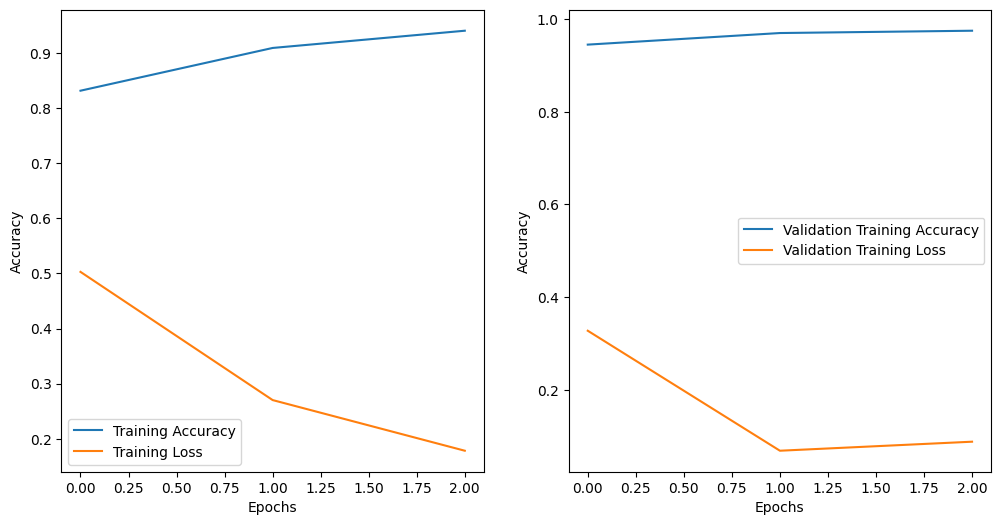

In [94]:
accuracy = history.history ['accuracy']
val_accuracy = history.history ['val_accuracy']

loss = history.history ['loss']
val_loss = history.history ['val_loss']

epochs = range (len (accuracy))

plt.figure (figsize = (12, 6))

plt.subplot (1, 2, 1)
plt.plot (epochs, accuracy, label = 'Training Accuracy')
plt.plot (epochs, loss, label = 'Training Loss')
plt.xlabel ('Epochs')
plt.ylabel ('Accuracy')
plt.legend ()

plt.subplot (1, 2, 2)
plt.plot (epochs, val_accuracy, label = 'Validation Training Accuracy')
plt.plot (epochs, val_loss, label = 'Validation Training Loss')
plt.xlabel ('Epochs')
plt.ylabel ('Accuracy')
plt.legend ()

plt.show ()

### Predictions and Submission Formatting

In [86]:
predictions = model.predict(test_generator, steps=test_generator.n // BATCH_SIZE + 1)
predicted_classes = np.argmax(predictions, axis=1)

class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
predicted_labels = [idx_to_class[i] for i in predicted_classes]

submission_df = pd.DataFrame({
    'id': test['id'][:len(predicted_labels)],
    'class': predicted_labels
})

26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step


In [98]:
submission_df.tail ()

,id,class
124,1125,Soccer
125,1126,Basketball
126,1127,Soccer
127,1128,AmericanFootball
128,1129,Soccer


In [100]:
submission_df.to_csv ('submission.csv', index = False)